# Causal probabilistic programming without tears

Despite the tremendous progress over the last several decades in reducing
causal inference to statistical practice, the \"causal revolution\"
proclaimed by Judea Pearl and others remains incomplete, with a sprawling and
fragmented literature inaccessible to non-experts and still somewhat
isolated from cutting-edge machine learning research and software tools.

Probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models. 

In this tutorial we elaborate on this idea with three key observations inspiring Causal Pyro's design, and outline a causal Bayesian workflow for using Causal Pyro to answer causal questions.

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a
probability distribution over a set of variables, but programs often contain more information than just the joint distributions they induce. In practice, when we write probabilistic programs in languages like Pyro we often bring to bear knowledge of causal relationships between variables, and implicitly, how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability
distributions, indexed by a set of *interventions*. This set always includes a trivial *identity intervention*, which maps to the usual (acausal) joint distribution over random variables induced by simply executing the program. However, for other interventions the resulting joint distribution can differ significantly, as we'll see later throughout this tutorial.

Somewhat less formally, causal models using these (nontrivial) interventions are useful when we want to represents hypothetical changes to a domain, such as a policy the encourages people to stop smoking. To ground this out a bit more concretely, consider the following Pyro program
describing a causal model relating three random variables, *stress*, *smokes*, and *cancer*.


Note: Later we'll see how to think of interventions as program transformations. Causal Pyro defaults to the trivial *identity intervention* if none are applied explicitly. This result of applying this identity intervention to a causal model is sometimes called a *observational model* or *factual model*.

In [1]:
import pyro
from pyro.distributions import Bernoulli

def causal_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

Our `causal_model` takes as input three sets of parameters, here just marginal and conditional probability tables, and returns a sample from the joint distribution over a single individual's *stress*, *smokes*, and *cancer* attributes. For now let's just choose some parameters by hand, but later we'll see how we can place priors over these parameters to express broader uncertainty and enable Bayesian causal inference. 

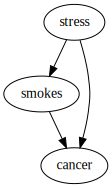

In [2]:
import torch

stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(causal_model, (stress_pt, smokes_cpt, cancer_cpt))



Fortunately, all causal models written in Causal Pyro compose freely with the probabilistic programming tooling in Pyro. Without belaboring the details, Pyro provides support for probabilistic modeling and inference with a set of composable *effect handlers*, which can be thought of as context managers that provide nonstandard interpretation of `pyro.sample` statements in Pyro programs. For more background on Pyro and its use of effect handlers, see https://pyro.ai/examples/intro_long.html and https://pyro.ai/examples/effect_handlers.html. Perhaps not surprisingly, Causal Pyro's main capabilities also make heavy use of similar effect handlers.

As an example, using Pyro's `plate` effect handler, we can represent repeated samples from the `causal_model` to yield a joint distribution of an entire population of individual's attributes. 

In [3]:
n_individuals = 10000

with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = causal_model(stress_pt, smokes_cpt, cancer_cpt)

print(stress_obs.shape, smokes_obs.shape, cancer_obs.shape)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000])


Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke
and how likely they are to get cancer. To understand this relationship a bit better, we can visualize the simulated observations from our model.

[Text(0.5, 1.0, 'Observational Data')]

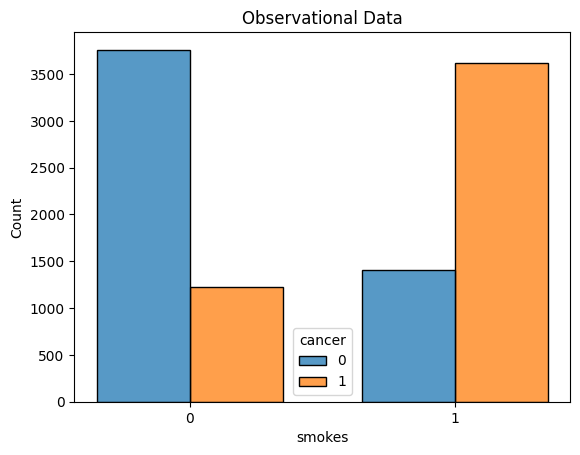

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)

frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs).set(title='Observational Data')

As we can see clearly, our model tells us that individuals who smoke are much more likely to get cancer than individuals
who don't. Of the ~5,000 simulated individuals who smoke ~3600 got cancer, roughly 72% of the smokers. Of the 
remaining ~5,000 simulated individuals who did not smoke only ~1,200 individuals got cancer, a much lower 24% of the smoking population.

So far we have a program that describes the distribution over data given model parameters. 
Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above
with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space"
induces a joint distribution over data.

(TODO: replace SCM with "program" and change colors a bit.)

![title](figures/Conditional_Distribution_of_Data.png)

Simulating from our `causal_model` is certainly interesting and informative, but it doesn't exactly give us answers to what what we're interested in. Instead, we want to know to what extent smoking *causes* cancer, not just whether smoking is associated with cancer. To answer this question, we can instead sample from modified versions of our model in which individuals are forced to smoke or not smoke, regardless of their level of stress. We can represent these kinds of modifications as **interventions**, and implement them in Causal Pyro as a special kind of program transformation. Later we'll see how Causal Pyro helps to automate the application of these kinds of interventions, but to build some intuition let's first walk through what these new programs would look like if we built them by hand instead.

To ground this out a bit more concretely, consider the following two new Pyro programs; `always_smokes_model` and `never_smokes_model`, which closely resemble our original `causal_model` except  in how the *smokes* attribute is assigned. Specifically, we've replaced the expression `smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()` with the expressions `smokes = pyro.deterministic("smokes", torch.ones_like(stress))` and `smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))` respectively. In other words, we set the *smokes* variable to be tensors of either 1s or 0s, regardless of the individual's stress.

In [5]:
def always_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.ones_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

def never_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

# Let's imagine that we force half the people to always smoke and half to never smoke.
n_counterfactual_individuals = int(n_individuals/2)
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

Let's visualize a simulation from these new programs and compare against our original simulation.

[Text(0.5, 1.0, 'Thought Experiment')]

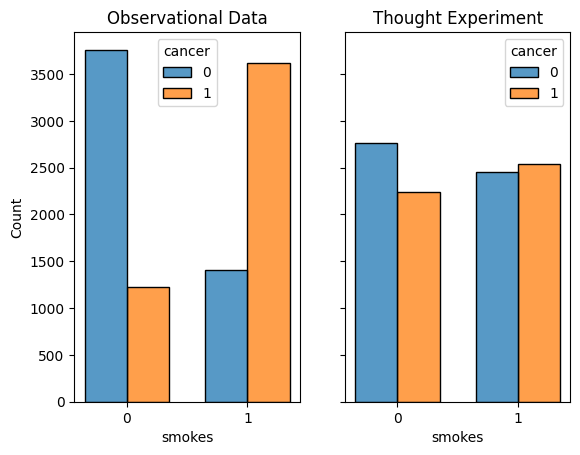

In [6]:
data_as = torch.concat((stress_as.reshape(-1, 1), smokes_as.reshape(-1, 1), cancer_as.reshape(-1, 1)), axis=-1)
data_ns = torch.concat((stress_ns.reshape(-1, 1), smokes_ns.reshape(-1, 1), cancer_ns.reshape(-1, 1)), axis=-1)
data_int = torch.concat((data_as, data_ns))

frame_int = pd.DataFrame(data_int.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

_, ax = plt.subplots(1, 2, sharey=True)

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[0]).set(title='Observational Data')
sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_int, ax=ax[1]).set(title='Thought Experiment')


Using our intervened models we can clearly see that changing the mechanism by which individuals choose whether or not to smoke dramatically changes the joint distribution between smoking and cancer. In our observational model, individuals who smoke are much more likely to get cancer than those who don't smoke. However, in our modified model in which individuals are forced to smoke or not smoke, the dependence between smoking and cancer nearly disapears.

This phenomenon we're observing in this (contrived) example is known as confounding. Here, the reason we see a statistical dependency between smoking and cancer in our original `causal_model` without any interventions is because of the individuals' stress. Given the parameters we happened to choose, individuals who are stressed are more likely to smoke and stress causes an increase in cancer. The confounding effect of stress dissapears in our intervened programs, as stress no longer influences whether individuals smoke or not.

Thusfar we've accomplished some limited form of causal reasoning by manually rewriting our original program, replacing the mechanism for how individuals choose to smoke directly in Pyro's syntax, and then simulating from the new programs. In fact, even though we called our program a `causal_model`, we haven't seen anything that we couldn't already do in an ordinary probabilistic programming language. 

This manual approach is perfectly reasonable in these kinds of simple scenarios where we have a single model and a single "thought experiment" we want to explore. However, as we'll see throughout these tutorials and examples, reasoning about cause and effect can often involve much more complicated compositions of program transformations. For example, in our mediation analysis example (TODO: add pointer to example) we'll need to simulate multiple counterfactual models simultaneously, with intervention assignments in one model that depend on simulated outcomes in another. 

One of the key insights behind Causal Pyro (and borrowed from Pearl's structural formalism) is that these kinds of interventions can be represented as model agnostic program transformations, i.e. a function $I: \mathcal{P} \rightarrow \mathcal{P}$, where $\mathcal{P}$ is the space of programs in our language. In Causal Pyro, and in many formalisms for causal models, we'll assume that models satisfy a kind of locality-preserving property known as autonomy (TODO: cite https://academic.oup.com/oep/article-abstract/41/1/15/2364178?redirectedFrom=fulltext). This autonomy property implies that interventions can be accurately represented as an alteration of a small number of model components, and all other model components (and the causal relationships among them) remain unchanged.

In that vein, Causal Pyro addresses the complexity of causal reasoning by automating a number of probabilistic program transformations; including interventions, construction of parallel counterfactual worlds, and (as we'll see in subsequent tutorials) automatic reparameterization for counterfactual or "what if" reasoning. 

For example, we can instead implement `always_smokes_model` and `never_smokes_model` succinctly as follows, using Causal Pyro's `do` program transformation. As the name implies, this special function `do` operates very similarly to the $do$ operator used with structural causal models and causal graphical models. Here, `do` takes as input a probabilistic program and a dictionary describing the intervention assignment (see TODO for details) and returns a transformed probabilistic program with the intervention applied. For example, the following one-liners produce probabilistic programs that are equivalent to the `always_smokes_model` and `never_smokes_model`s we wrote by hand earlier.

In [7]:
from causal_pyro.query.do_messenger import do

always_smokes_model = do(causal_model, {"smokes": torch.tensor([1.])})
never_smokes_model  = do(causal_model, {"smokes": torch.tensor([0.])})

Just like our original implementation of `always_smokes_model` and `never_smokes_model`, these transformed models are probabilistic programs in Pyro, and can thus freely compose with all of Pyro's effect handlers.
For example, we can again use an `plate` effect handler to sample from a population of individuals.

In [8]:
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)


Before we move on, let's be a bit more precise about the question we'd like to answer using our causal model. One quantity we may wish to estimate is how much, on average, smoking increases the risk of cancer. We can define this *average treatment effect* mathematically as the difference between the proportion of individuals who get cancer under our `always_smokes_model` and our `never_smokes_model`.

In [9]:
ATE = cancer_as.float().mean() - cancer_ns.float().mean()
ATE

tensor(0.0542)

To recap, so far we've constructed a causal describing how data is generated in the actual world we can observe, which we called `causal_model`, and transformedour causal model to represent our thought experiments, or interventions, resulting in the `always_smokes_model` and `never_smokes_model` programs. Then, we sampled from our original and transformed models to generate simulated outcomes, and finally summarized the simulated outcomes yielding an answer to our causal query. Again, this process can be viewed somewhat abstractly as follows:

![title](figures/Interventional_Conditional.png)

In this section we've seen that a probabilistic program specifies a causal model in that it;
  1. specifies a "default" or "observational" joint distribution over the
variables of interest according to the usual semantics of probabilistic
programming languages
  2. encodes the necessary information to
determine the new joint distribution under an arbitrary intervention
(program transformation)---apply the transformation and derive the new
joint distribution.


## Observation 2: causal uncertainty is probabilistic uncertainty

So far we've shown how to define a causal model as a probabilistic program, and how to use Causal Pyro's intervention program transformations, `do`, to answer causal questions. However, in doing so we made a few very strong assumptions.

1. We assumed that we knew the parameters of our causal model exactly, i.e. we asserted *how much* variables causally affect which other variables.
2. We assumed that we knew the structure of our causal model exactly, i.e. we asserted *which* variables causally affect which other variables.

In this section we'll show how we can use Causal Pyro to substantially relax these assumptions, representing broad uncertainty over causal structure and parameters. Simply put, we can introduce uncertainty over causal model parameters the same way we would write any other Bayesian hierarchical model, by composing a prior distribution over parameters with our original causal model.

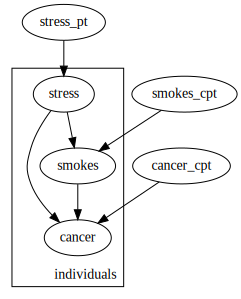

In [10]:
from pyro.distributions import Beta

def parameter_prior():

    stress_pt = pyro.sample("stress_pt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, smokes_cpt, cancer_cpt

def bayesian_causal_model(n_individuals):
    stress_pt, smokes_cpt, cancer_cpt = parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return causal_model(stress_pt, smokes_cpt, cancer_cpt)

pyro.render_model(bayesian_causal_model, (n_individuals,))

By repeatedly sampling from the observational model we can see how our new uncertainty about marginal and conditional probability tables propagates to uncertainty about the relationship between smoking and cancer.

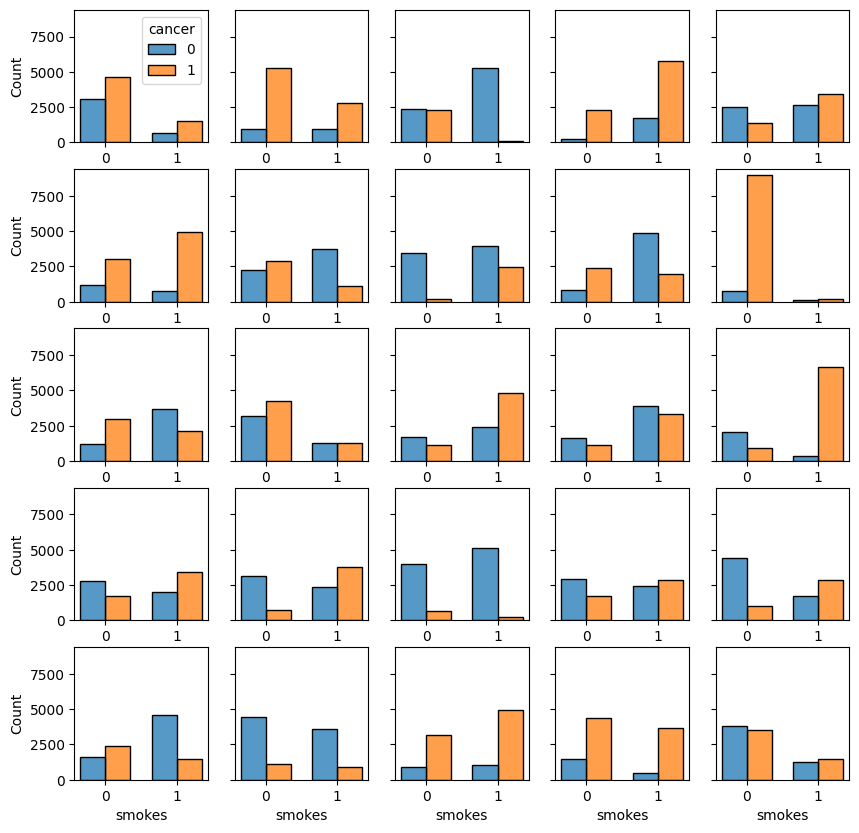

In [11]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_obs, smokes_obs, cancer_obs = bayesian_causal_model(n_individuals)

    data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)
    frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[row, col], legend = (False if i else True))

Earlier we showed how to use Causal Pyro's `do` program transformation to apply an intervention to our original `observational_model` that took known parameters as input. It turns out that interventions can be called both inside and outside of `pyro.plate`s, and freely compose with nested probabilistic program function calls. In practice, this means that we can easily (i) define interventions that are themselves parameterized by random choices, and (ii) apply our intervention to the Bayesian variant of our observational model above without rewriting the model to generate a Bayesian variant of our intervened model with the same prior.

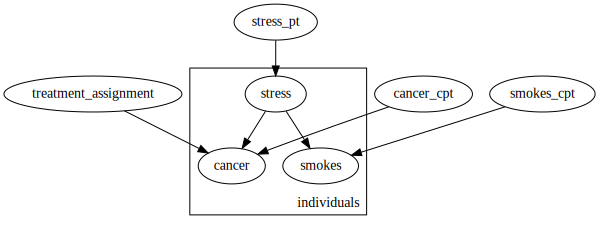

In [19]:
def randomized_intervention(model, intervention_variable, n_individuals):
    def new_model(*args, **kwargs):
        intervention_assignment = pyro.sample("treatment_assignment", Bernoulli(torch.ones(n_individuals) * 0.5).to_event(1)).long()
        return do(model, {intervention_variable: intervention_assignment})(*args, **kwargs)
    
    return new_model

bayesian_randomized_model = randomized_intervention(bayesian_causal_model, "smokes", n_individuals)

# TODO: explain this rendering a bit.
pyro.render_model(bayesian_randomized_model, (n_individuals,))

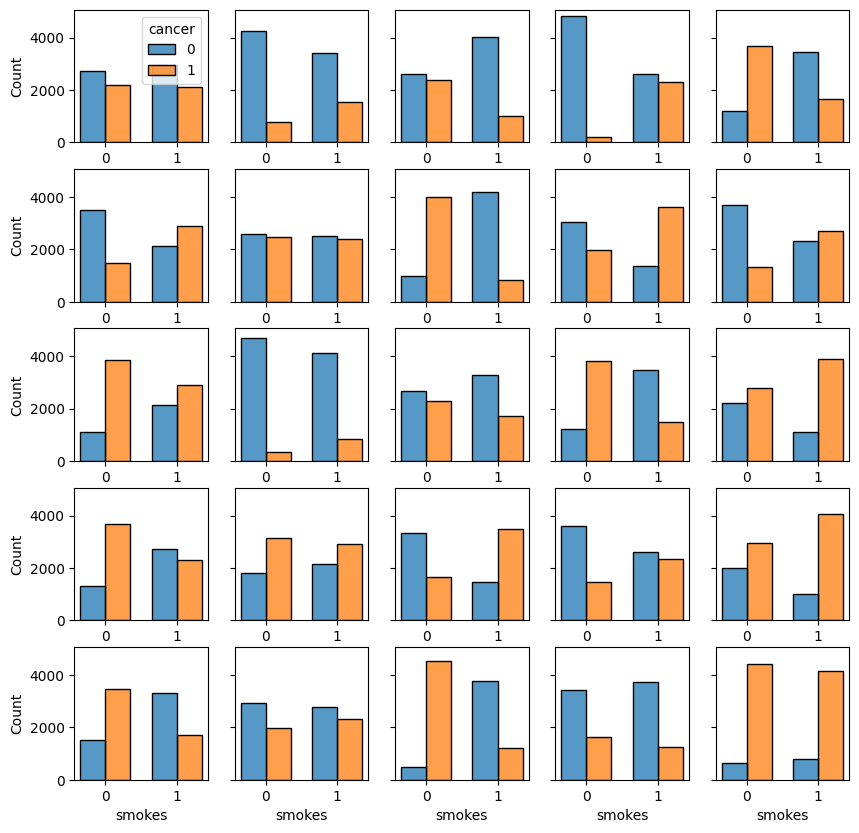

In [20]:
bayesian_randomized_model = randomized_intervention(bayesian_causal_model, "smokes", n_individuals)

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = bayesian_randomized_model(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

In addition to adding prior distribution over model parameters given a known structure, we can further add uncertainty to our causal assumptions by writing a probabilistic program that selects between multiple probabilistic programs depending on the result of a discrete random choice. Again, we can quickly expand the complexity of our uncertain causal assumptions without needing to rewrite our original `causal_model` from scratch, as probabilistic programs in Causal Pyro are compositional.

In the context of our original smoking example, let's pretend that we don't know whether smoking influences cancer, or whether cancer influences smoking. (This might seem somewhat nonsensical now, but it could have been a "plausible" hypothesis 70 years ago.) Graphically, this would be represented as uncertainty about the causal edge between 'smokes` and 'cancer' variables. To implement this uncertainty in Causal Pyro, we first need to write a new program that represents the alternative observational model.

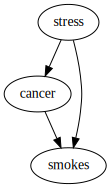

In [21]:
def alt_causal_model(stress_pt, cancer_cpt, smokes_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress])).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress, cancer])).long()

    return stress, smokes, cancer

stress_pt = torch.tensor([0.5])
cancer_cpt  = torch.tensor([0.2, 0.8])
smokes_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(alt_causal_model, (stress_pt, cancer_cpt, smokes_cpt))

Again, we can place a prior over parameters for this alternative model, representing our uncertainty about the strength of effects.

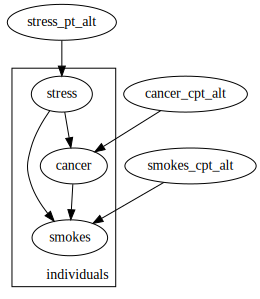

In [25]:
def alt_parameter_prior():

    stress_pt = pyro.sample("stress_pt_alt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt_alt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt_alt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, cancer_cpt, smokes_cpt

def alt_bayesian_causal_model(n_individuals):
    stress_pt, cancer_cpt, smokes_cpt = alt_parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return alt_causal_model(stress_pt, cancer_cpt, smokes_cpt)

pyro.render_model(alt_bayesian_causal_model, (n_individuals,))

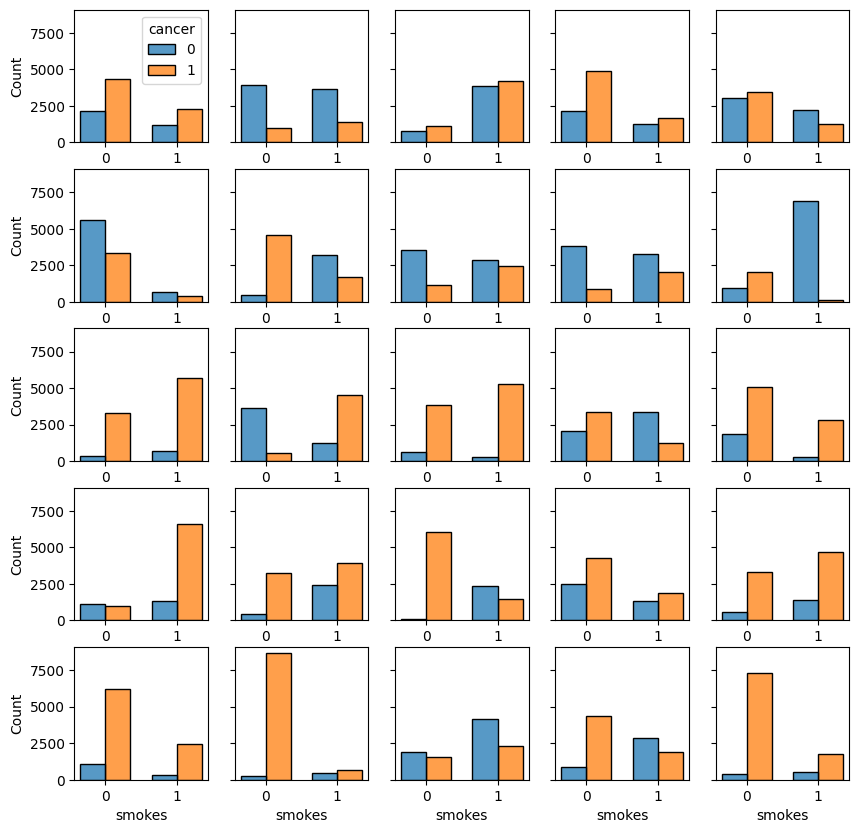

In [26]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_alt, smokes_alt, cancer_alt = alt_bayesian_causal_model(n_individuals)

    data_alt = torch.concat((stress_alt.reshape(-1, 1), smokes_alt.reshape(-1, 1), cancer_alt.reshape(-1, 1)), axis=-1)
    frame_alt = pd.DataFrame(data_alt.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_alt, ax=ax[row, col], legend = (False if i else True))

Looking at just samples from the observational distribution, this new alternative structure doesn't obviously result in a different joint distribution between smoking and cancer before applying an intervention. However, this will not be the case for the interventional distribution over random variables. In our new alternative candidate model, smoking has no effect on cancer whatsoever, and thus we shouldn't ever see any difference between cancer rates between individuals when smoking is randomized.

To see this conclusion visually, we can again apply an intervention to this new model and then simulate from the transformed model representing our randomization thought experiment.

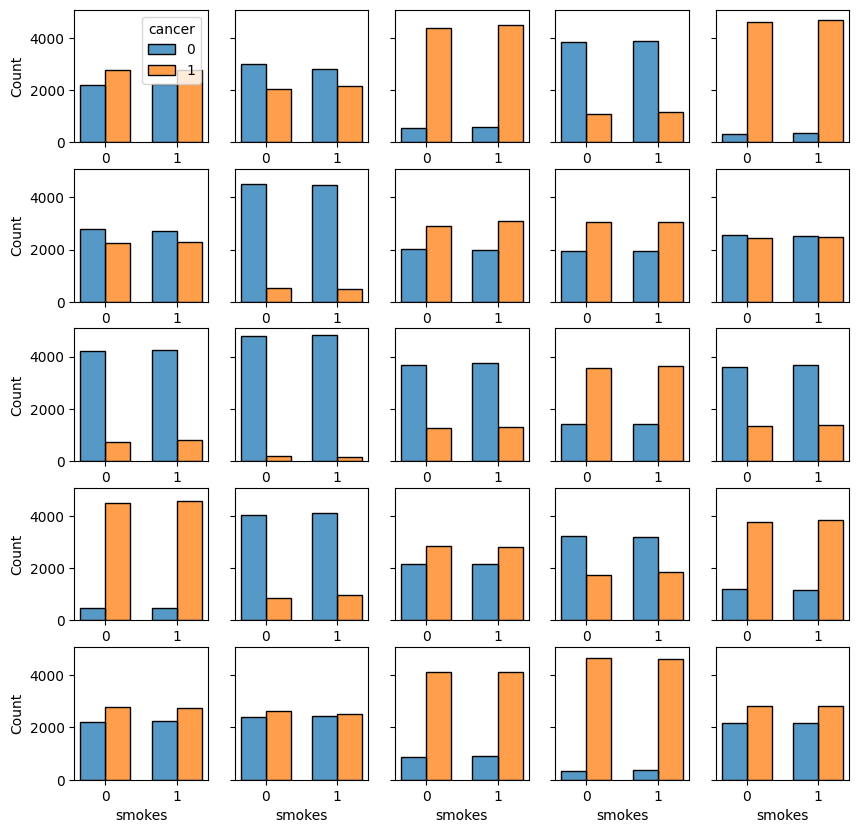

In [27]:
alt_bayesian_randomized_model = randomized_intervention(alt_bayesian_causal_model, "smokes", n_individuals)

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = alt_bayesian_randomized_model(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

As expected, once we've randomized whether an individual smokes we no longer see any association between smoking and cancer under this alternative model.

Using our two probabilistic programs representing different plausible structures (and with uncertain parameters), we can write a probabilistic program that randomly chooses between them. 
Conceptually, this represents a scenario where we don't know whether smoking causes cancer or cancer causes smoking.

In [28]:
from pyro.distributions import Bernoulli

def bayesian_causal_model_unknown_structure(n_individuals):
    
    is_original_model = pyro.sample("is_original_model", Bernoulli(0.5))
    model = bayesian_causal_model if is_original_model else alt_bayesian_causal_model

    return model(n_individuals)

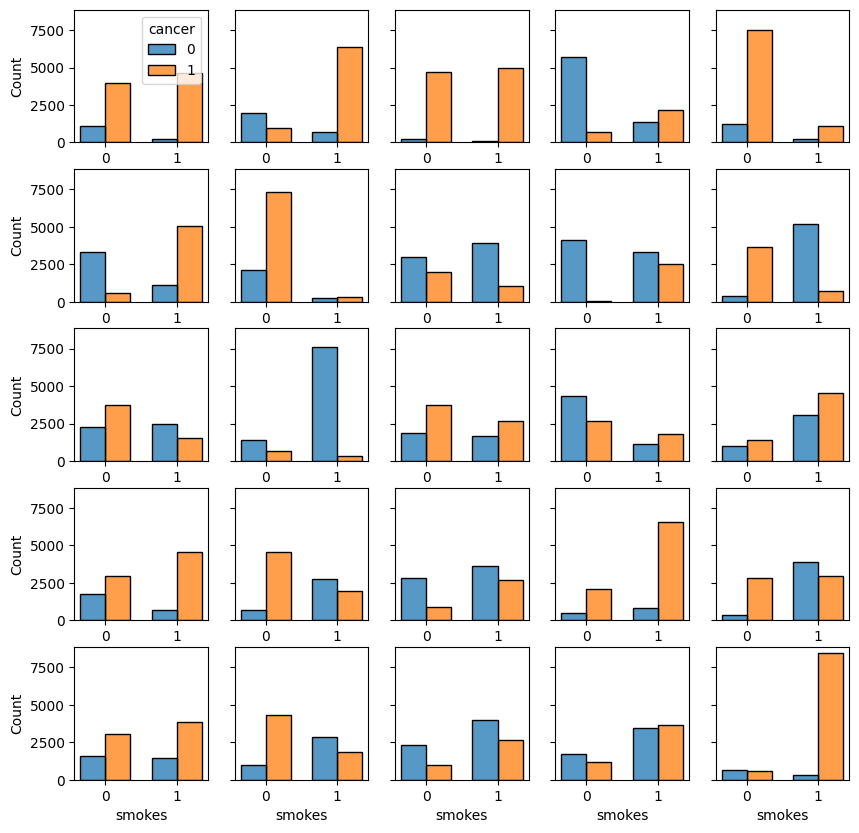

In [29]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_us, smokes_us, cancer_us = bayesian_causal_model_unknown_structure(n_individuals)

    data_us = torch.concat((stress_us.reshape(-1, 1), smokes_us.reshape(-1, 1), cancer_us.reshape(-1, 1)), axis=-1)
    frame_us = pd.DataFrame(data_us.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_us, ax=ax[row, col], legend = (False if i else True))

Earlier we showed that interventions in Casual Pyro compose freely with hierarchical Bayesian extensions of our original model with deterministic parameters.
Perhaps not surprisingly, interventions are still well-behaved even when applied to program with uncertainty over structure as well.

To see this, let's again apply our randomized intervention and visualize the results of repeated samples from our model with structural uncertainty. As expected, we see that some samples from this model with structural uncertainty show a difference in cancer rate between smokers and non-smokers (representing samples in which `is_original_model=1`)


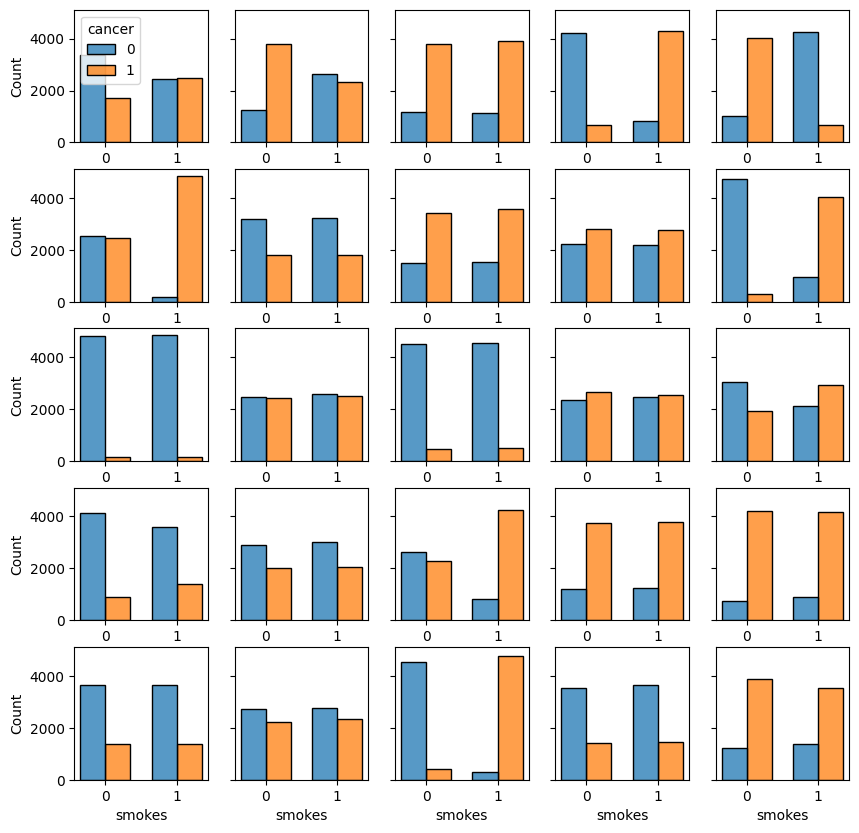

In [30]:
bayesian_randomized_model_unknown_structure = randomized_intervention(bayesian_causal_model_unknown_structure, "smokes", n_individuals)

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = bayesian_randomized_model_unknown_structure(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

Now that we've incorporated uncertainty about the structure *and* parameters, we can see that samples from the post-intervention
version of our program sometimes shows an effect of smoking on cancer and sometimes shows no effect. In other words, our uncertainty
over causal models naturally propagates to uncertainty over causal conclusions. We can visualize this flow of uncertainty in the following
(again somewhat cartoonish) diagram showing how information flows from observational probabilistic programs to interventions probabilistic programs
and subsequently to factual and counterfactual data.


![title](figures/Interventional_Marginal.png)

## Observation 3: causal inference is probabilistic inference


Thusfar we've seen how introducing intervention program transformations like `do` make it straightforward to model randomized experiments and to reason about the causal implications of (i) uncertainty over the strength of causal effects and (ii) uncertainty over causal structure.
We can call this progress *causal modeling*. In practice however, we often don't want to just posit causal knowledge about the world, we also want to update that knowledge in light of observational and experimental data. We'll call this
process of learning about cause and effect from data *causal inference*. The key insight underlying Causal Pyro is that taking a Bayesian approach to causal modeling as we've done thusfar means that causal inference simply reduces to 
probabilistic inference in what's known as a *multi-world* transformation of our original causal model. 

As we'll show in this section, to reduce causal inference to probabilistic inference we have to perform a few distinct steps:
- Transform our Causal Pyro program into a new Pyro program that represents a joint distribution over both factual outcomes, i.e. what actually happened, and counterfactual outcomes, i.e. what would have happened had we intervened. We'll call this a *twin world program*.
- Condition the factual outcomes in our twin world program according to some observed data.
- Run (approximate) posterior inference in the conditioned twin world program, resulting in an updated distribution over both parameters and counterfactual outcomes.

To see this more clearly, let's introduce another program transformation provided by Causal Pyro, the `TwinWorldCounterfactual` effect handler. Intuitively, this new effect handler tells Causal Pyro that any `pyro.sample` statements
that are downstream of an intervention should be sampled twice, once for the observable world without interventions and once for the counterfactual world with interventions applied.

In [31]:
from causal_pyro.counterfactual.handlers import TwinWorldCounterfactual

stress_r_sw, smokes_r_sw, cancer_r_sw = bayesian_randomized_model(n_individuals)

with TwinWorldCounterfactual(dim=-2):
    stress_r_tw, smokes_r_tw, cancer_r_tw = bayesian_randomized_model(n_individuals)

print("Single World Stress Shape = {}".format(stress_r_sw.shape))
print("Single World Smokes Shape = {}".format(smokes_r_sw.shape))
print("Single World Cancer Shape = {}".format(cancer_r_sw.shape))
print("Twin World Stress Shape = {}".format(stress_r_tw.shape))
print("Twin World Smokes Shape = {}".format(smokes_r_tw.shape))
print("Twin World Cancer Shape = {}".format(cancer_r_tw.shape))

Single World Stress Shape = torch.Size([10000])
Single World Smokes Shape = torch.Size([10000])
Single World Cancer Shape = torch.Size([10000])
Twin World Stress Shape = torch.Size([10000])
Twin World Smokes Shape = torch.Size([2, 10000])
Twin World Cancer Shape = torch.Size([2, 10000])


Looking at the shapes of these tensors give a bit of intuition about how this `TwinWorldCounterfactual` transforms the execution of our `bayesian_randomized_model` representing a randomized experiment condition.

- All three of the tensors sampled from the `bayesian_randomized_model` without using the `TwinWorldCounterfactual` handler have the same size, `torch.Size([10000])`, where each element represents a distinct individual with an intervention applied.
- The returned `stress_r_mw` tensor using the `TwinWorldCounterfactual` is the same size as the version without the `TwinWorldCounterfactual` handler, `stress_r_sw`. This is because the `stress` variable is upstream of the intervened `smokes` variable, and is thus always identical in both factual and counterfactual worlds. Causal Pyro automates this reasoning.
- The returned `smokes_r_sw` and `cancer_r_sw` tensors using the `TwinWorldCounterfactual` handler has been expanded to a tensor of size `torch.Size([2, 10000])`, where `smokes_r_mw[0, :]` and `cancer_r_mw[0, :]` are sampled from the observational distribution and `smokes_r_mw[1, :]` and `cancer_r_mw[1, :]` are sampled from the interventional distribution. Here, the `dim` argument of the `TwinWorldCounterfactual` handler dictates which tensor dimension denotes the difference between observational and interventional distributions.

Using somewhat light and informal mathematical notation for brevity, the tensors returned from the model transformed using the `TwinWorldCounterfactual` handler represent samples from the joint distribution over $p(stress, smokes, cancer, stress_{cf}, smokes_{cf}, cancer_{cf})$, where $stress$, $smokes$, and $cancer$ are the random variables representing individual attributes without an intervention and $stress_{cf}$, $smokes_{cf}$, and $cancer_{cf}$ are the random variables representing individual attributes in our randomized experiment. However, as we mentioned before, causal inference is about coming to causal conclusions combining modeling assumptions *and* data, not just modeling assumptions along. However, now that we have a model representing a joint distribution over both observational and interventional data, we can condition our model and apply approximate inference techniques just as we would any other Pyro model. For example, using Pyro's support for stochastic variaitional inference we can obtain an approximate conditional distribution $p(stress_{cf}, smokes_{cf}, cancer_{cf}|stress, smokes, cancer)$.

To see how Causal Pyro enables causal inference, let's first generate some synthetic observational data for $stress$, $smokes$, and $cancer$ in which approximately half of the individuals smoke, and those who do are much more likely to have cancer than those who don't.

In [32]:
stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

n_individuals = 10000
with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = causal_model(stress_pt, smokes_cpt, cancer_cpt)

Now that we have synthetic data, we can condition on it inside of the `TwinWorldCounterfactual` handler we saw earlier. This creates a new model `twin_model_conditioned`, that represents the conditional distribution we're interested in, $p(stress_{cf}, smokes_{cf}, cancer_{cf}|stress, smokes, cancer)$.

In [33]:
twin_model_conditioned = TwinWorldCounterfactual(dim=-2)(pyro.condition(bayesian_randomized_model, data={"smokes":smokes_obs.float(), "cancer": cancer_obs.float(), "stress": stress_obs.float()}))

After using the `TwinWorldCounterfactual` and the `do` handlers, the resulting model can be treated as an ordinary Pyro program. Just as in Pyro, conditioning a model on data means that we can no longer sample directly from the `twin_model_conditioned` model by just running the program; instead we need to run an *approximate inference algorithm*.

Thankfully, because we've used Causal Pyro's program transformations to construct an ordinary Pyro program, we can use Pyro's built-in support for approximate inference. To see this, let's run stochastic variational inference with a Gaussian mean-field variational approximation.

In [34]:
from pyro.poutine import block
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI

initial_lr = 0.03
adam = pyro.optim.Adam({'lr': initial_lr})
elbo = pyro.infer.Trace_ELBO()

guide = AutoNormal(block(twin_model_conditioned, hide=['treatment_assignment', 'stress', 'cancer_unobserved', 'stress_unobserved', 'smokes_unobserved']))

svi = SVI(twin_model_conditioned, guide, adam, loss=elbo)

num_iterations = 1000

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(n_individuals)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / n_individuals))

/Users/sam-basis/opt/anaconda3/envs/causal_pyro/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'treatment_assignment', 'cancer_unobserved'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[iteration 0001] loss: 3.4750
[iteration 0101] loss: 2.6964
[iteration 0201] loss: 2.6841
[iteration 0301] loss: 2.6766
[iteration 0401] loss: 2.6578
[iteration 0501] loss: 2.6837
[iteration 0601] loss: 2.6681
[iteration 0701] loss: 2.6639
[iteration 0801] loss: 2.6819
[iteration 0901] loss: 2.6638


We can visualize the resulting posterior distribution over intervened models just as we did before conditioning on data.

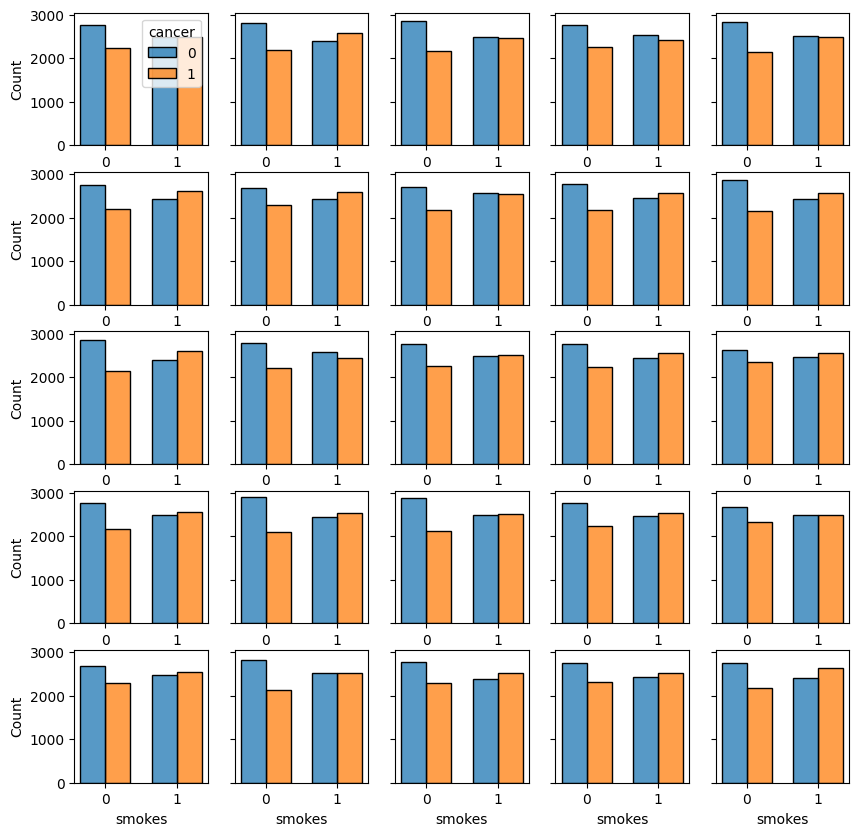

In [35]:
# These look like the "thought experiment" plot from the beginning of the notebook. Great!
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

predictive = pyro.infer.Predictive(twin_model_conditioned, guide=guide, num_samples=25, return_sites=("stress", "treatment_assignment", "cancer_unobserved"))

result = predictive(n_individuals)

for i in range(25):

    row = i % 5
    col = i // 5
    
    stress = result["stress"][i, 0, :]
    smokes = result["treatment_assignment"][i, 0, 0, :]
    cancer = result["cancer_unobserved"][i, 1, :]
    
    data = torch.concat((stress.reshape(-1, 1), smokes.reshape(-1, 1), cancer.reshape(-1, 1)), axis=-1)
    frame = pd.DataFrame(data.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame, ax=ax[row, col], legend = (False if i else True))

These plots show that after conditioning on data we're fairly confident smoking has a small effect on cancer, but much less of an effect than we would have concluded if we naively inspected the data.

Using our cartoonish diagrams from before, we can see how data informs our updated belief about causal models, which then propagate forward into counterfactual outcomes and causal conclusions. Even though we've only observed data in a world where people choose whether to smoke or not of their own free will, this observed data tells us something about which causal models are plausible. Importantly, this process of mapping data in one world to conclusions in another (e.g. a world in which people are randomly assigned smoking behavior), requires assumptions. When using Causal Pyro, the models we write encode those assumptions implicitly by how interventions transform them. In subsequent tutorials we'll discuss this subtly and consideration in more detail. For now, remember that this ability to reduce causal inference to probabilistic inference doesn't come out of thin air.

![title](figures/Interventional_Posterior.png)

## A Causal Bayesian Workflow

To conclude this tutorial, let's zoom out and think about how to use Causal Pyro for causal inference problems more broadly. Here, we elaborate on the program transformation-based operations we've demonstrated thusfar fit into the standard statistical practice embodied by Peterson and van der Laans' *Causal Roadmap* (TODO: cite https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4077670/). Here, we show the original causal roadmap components in **bold**, and how to express them in Causal Pyro in *italics*.


1. **Specify knowledge about the system to be studied using a causal model**. *This knowledge should be expressed by the ordering and functional/distributional relationships of random variables in a Pyro program*.
2. **Specify the observed data and their link to the causal model.** *Express the relationships between observations and the causal model by (optionally) adding additional model components representing mechanisms for missing data, and by conditioning the original Pyro program on observations*.
3. **Specify a target causal quantity.** *Express the target causal quantity as a combination of program transformations including world-splitting (e.g. `TwinWorldCounterfactual`), intervention (`do`), and probabilistic conditioning (`condition`).*
4. **Assess identifiability.** *Currently Causal Pyro does not support automated methods for assessing identifiability. Future versions will implement non-parametric methods like the do-calculus (TODO: cite), or numerical approaches such as Simulation-based identifiability (TODO: cite).*
5. **State the statistical estimation problem**. *Causal Pyro does not currently distinguish between causal estimation and statistical estimation. Therefore, this component of the original causal roadmap is not covered by Causal Pyro. In future versions we may implement nonparametric causal inference utilities using free variables, in which case causal reasoning (such as nonparametric identifiability analysis) and statistical estimation may occur over different models for the same process.*
6. **Estimate.** *Use Pyro's approximate inference capabilities (e.g. SVI) to estimate the posterior distributions over counterfactual variables of interest.
7. **Interpret.** *Causal Pyro does not currently provide any support for interpretting the validity of causal assumptions or conclusions.*

Importantly, once we arrive at step 6, we can again dispatch an entirely seperate *Bayesian Workflow* (TODO: cite https://arxiv.org/abs/2011.01808) for assessing the validity of probabilistic modeling and inference. Note: while the causal roadmap and the Bayesian workflow are mostly orthogonal, there are some special considerations that can be made to make model criticism more effective in a causal inference setting (TODO: cite https://arxiv.org/pdf/1610.09037.pdf). 